<div>
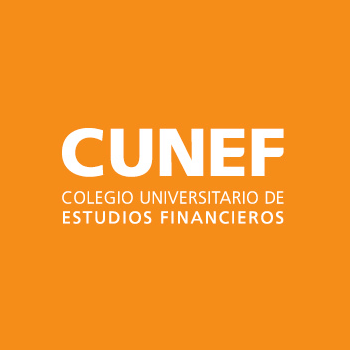
</div>

# **Zoom Video Communications (ZM)**

## *Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de sus datos*

Se procede a continuación a leer el archivo CSV del precio histórico y volumen de acciones de la empresa Zoom Video Communications (ZM).
- Fuente: https://finance.yahoo.com/quote/ZM/history?p=ZM

In [6]:
df_zm = pd.read_csv("ZM2.csv")
df_zm['Date'] = pd.to_datetime(df_zm['Date'])
df_zm = df_zm.set_index("Date")
df_zm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-18,65.000000,66.000000,60.320999,62.000000,62.000000,25764700
2019-04-22,61.000000,68.900002,59.939999,65.699997,65.699997,9949700
2019-04-23,66.870003,74.168999,65.550003,69.000000,69.000000,6786500
2019-04-24,71.400002,71.500000,63.160000,63.200001,63.200001,4973500
2019-04-25,64.739998,66.849998,62.599998,65.000000,65.000000,3863300
...,...,...,...,...,...,...
2022-08-04,114.070000,115.000000,110.139999,112.860001,112.860001,2149800
2022-08-05,110.000000,114.320000,108.739998,113.849998,113.849998,2639500
2022-08-08,114.769997,119.820000,113.820000,114.739998,114.739998,2832500


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [7]:
type(df_zm) # comprobación del tipo de dato

pandas.core.frame.DataFrame

In [8]:
ohlc_dict = {'Open':'first',
             'High':'max',
             'Low':'min',
             'Close': 'last',
             'Volume': 'sum'}
df_zm = df_zm.resample('MS', # para que remuestree a primeros de mes 
                       closed='right', 
                       label='right').agg(ohlc_dict)
df_zm.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-01,119.389999,126.440002,95.720001,99.570000,74287300
2022-06-01,99.150002,112.870003,79.029999,107.650002,151407900
2022-07-01,107.430000,123.730003,102.120003,110.970001,106390600
2022-08-01,110.559998,124.050003,96.110001,105.389999,79756200
2022-09-01,103.040001,119.820000,102.900002,112.010002,22372300


## *Graficación de la serie temporal y análisis*

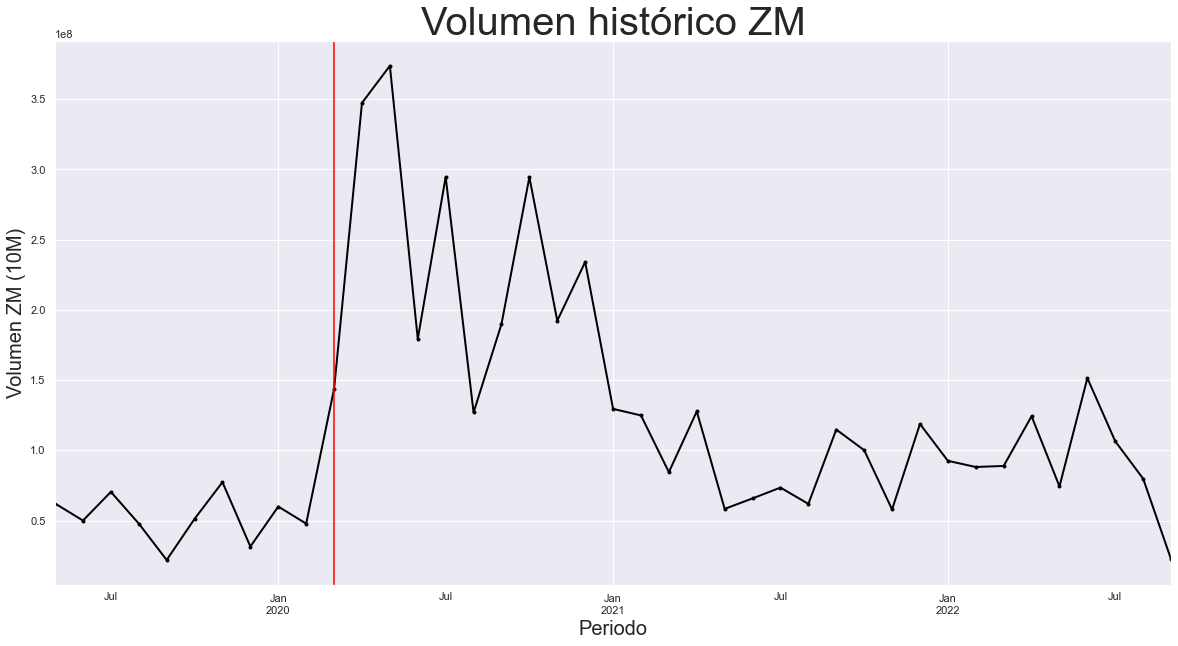

In [9]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_zm['Volume'].plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Volumen histórico ZM', fontsize = 40) 
fig.set_ylabel('Volumen ZM (10M)', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

Podemos comprobar que no existía previamente una tendencia hasta que inicia el periodo COVID-19 en marzo del 2020, que es cuando la empresa consigue generar un alto interés en los inversores durante ese año debido a que, por motivos de las restricciones por la pandemia, se propaga las videollamadas como medio para el teletrabajo, formaciones online y comunicación entre personas por lo general. 

A continuación, analizaremos mejor su estacionalidad y su tendencia mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [10]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [11]:
mean = split_and_summarize(df_zm, 'Volume', 4, np.mean)

variance = split_and_summarize(df_zm, 'Volume', 4, np.var)

In [12]:
A continuación vamos a analizar el comportamiento mensual:cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_9228/2878025227.py, line 1)

A continuación vamos a analizar el comportamiento mensual:

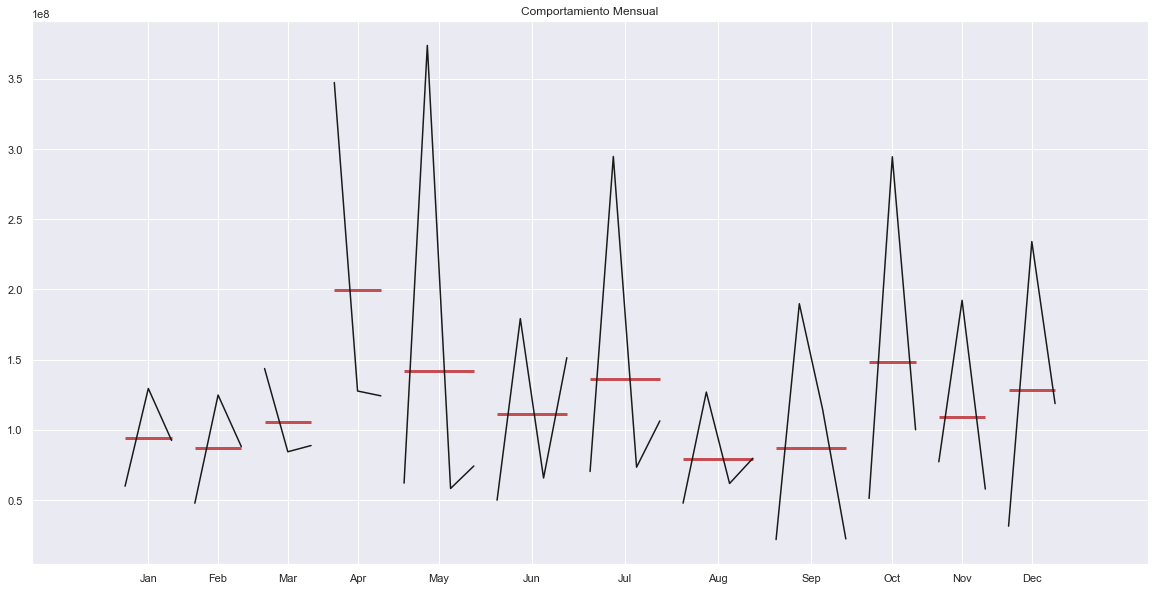

In [13]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_zm['Volume'], ax=ax)
ax.set_title('Comportamiento Mensual');

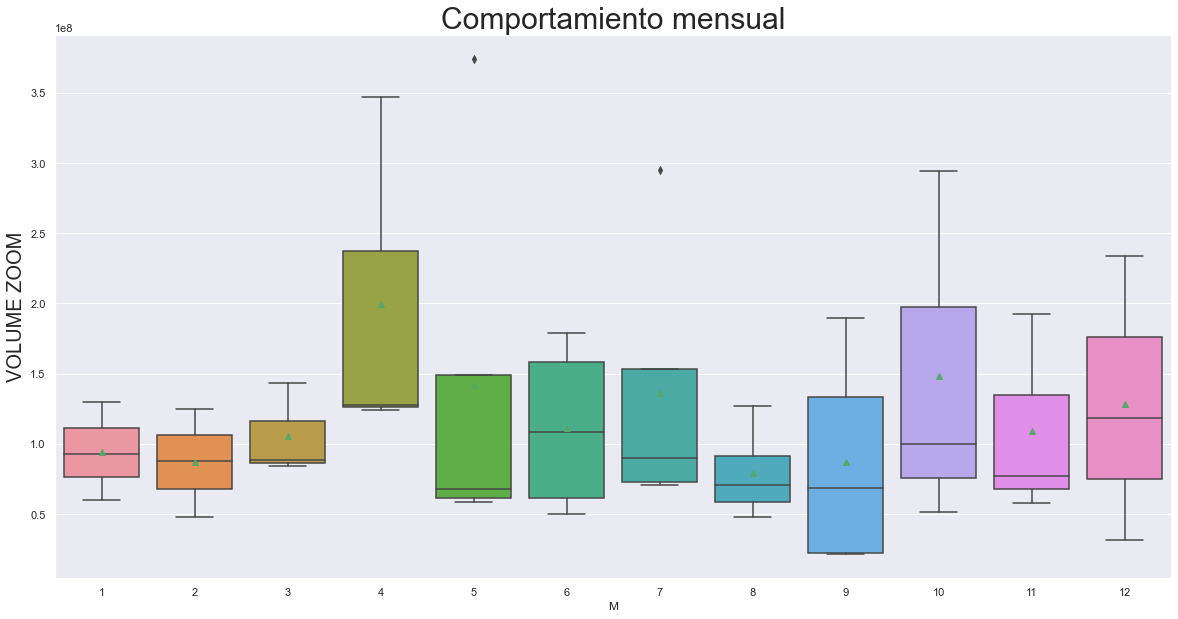

In [14]:
df_zm['M'] = df_zm.index.month
sns.boxplot(data = df_zm, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_ylabel('VOLUME ZOOM', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Por último, el desglose:

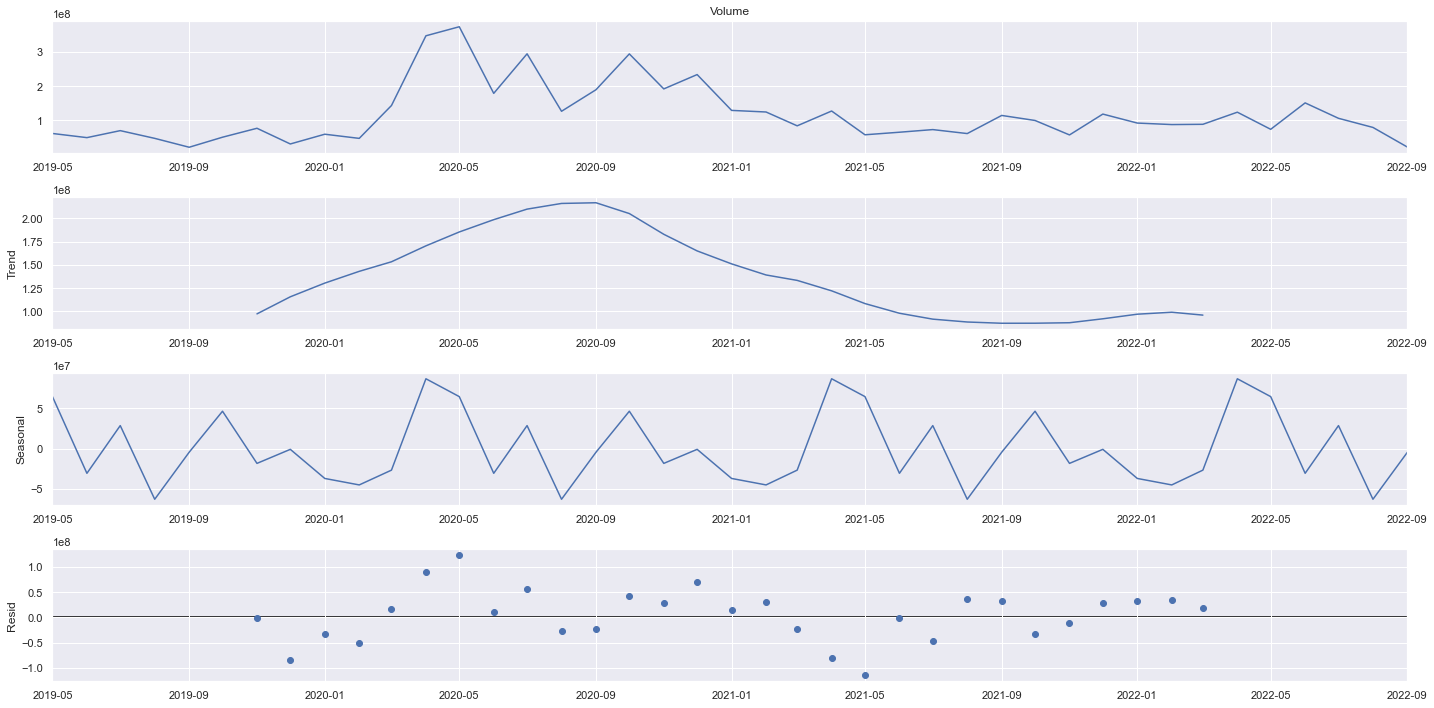

In [15]:
desglose = seasonal_decompose(df_zm['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Como conclusión, vemos que:
- La tendencia sube y genera interés cuando inicia la pandemia, pero después sigue una tendencia decreciente.
- No hay una estacionalidad, pues no existe ningún mes de más volumen de activos o ciclos. Tampoco tiene estacionariedad porque la media y la varianza no son constantes.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.